In [1]:
import time
import matplotlib
import numpy as np
import subprocess
import sys
import nibabel as nib
import os
from scipy.io import savemat, loadmat
import mat73
from scipy.ndimage import rotate
import numpy.matlib as matlib
import mat73
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
savedir = '/Users/elliottunstall/Desktop/Imperial/FYP/Example_cardiac_dataset'

def show_image(img, pixelMap):
    plt.imshow(img, extent=(pixelMap['X'].min(), pixelMap['X'].max(), pixelMap['Z'].max(), pixelMap['Z'].min()), origin='upper')
    plt.colorbar()

In [3]:
#! Takes long
# mesh = mat73.loadmat('/Users/elliottunstall/Desktop/Imperial/FYP/Example_cardiac_dataset/int_mesh_2490f.mat')['m']

Text(0.5, 1.0, 'Moving')

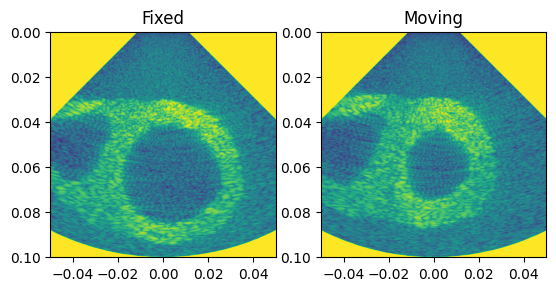

In [4]:
fixed = (mat73.loadmat(savedir + 'new_bmode_f1.mat')['blurry'])
moving = (mat73.loadmat(savedir + 'new_bmode_f50.mat')['blurry'])

pxm = mat73.loadmat(savedir + 'new_bmode_f1.mat')['pixelMap']

plt.figure()
plt.subplot(1,2,1)
plt.imshow(fixed, extent=(pxm['X'].min(), pxm['X'].max(), pxm['Z'].max(), pxm['Z'].min()), origin='upper')
plt.title('Fixed')
plt.subplot(1,2,2)
plt.imshow(moving, extent=(pxm['X'].min(), pxm['X'].max(), pxm['Z'].max(), pxm['Z'].min()), origin='upper')
plt.title('Moving')

In [86]:
import wrapper

# calculate deformation field
params = {'name': 'imregdemons',
          'smoothing': 1,
          'step_length':0.62,
          'metric':'SSD',
          'niter': 200,
          'npyramids':4}

deform_forward, deform_backward, output_image, execution_time = wrapper.implement_algorithm(fixed, moving, params)
deform_forward = deform_forward*0.0001
deform_backward = deform_backward*0.0001

suggest you rename the function to avoid a potential name conflict. 


Text(0.5, 1.0, 'Moving')

<Figure size 640x480 with 0 Axes>

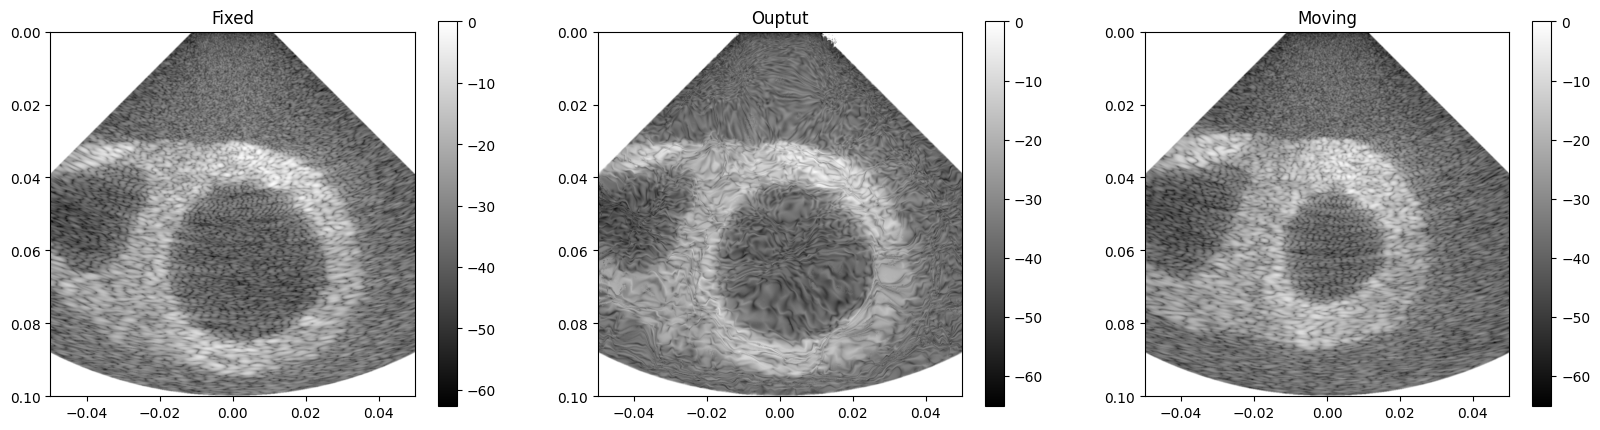

In [59]:
plt.gray()
plt.figure(figsize=(20, 5), dpi=100)
plt.subplot(1,3,1)
show_image(fixed, pxm)
plt.title('Fixed')
plt.subplot(1,3,2)
show_image(output_image, pxm)
plt.title('Ouptut')
plt.subplot(1,3,3)
show_image(moving, pxm)
plt.title('Moving')

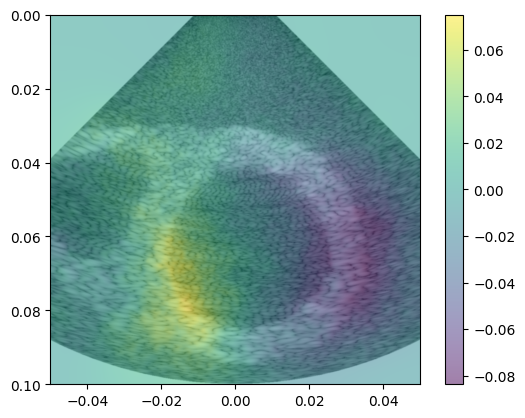

In [68]:
extent = pxm['X'].min(), pxm['X'].max(), pxm['Z'].max(), pxm['Z'].min()
plt.figure()

# Plot the first grayscale image
plt.imshow(fixed, cmap=plt.cm.gray, extent=extent, origin='upper')

# Plot the second image with viridis colormap
plt.imshow(deform_forward[:,:,0], cmap=plt.cm.viridis, extent=extent, origin='upper', alpha=0.5)

# Add a color bar for the second image (viridis colormap)
plt.colorbar()

plt.show()

<Figure size 640x480 with 0 Axes>

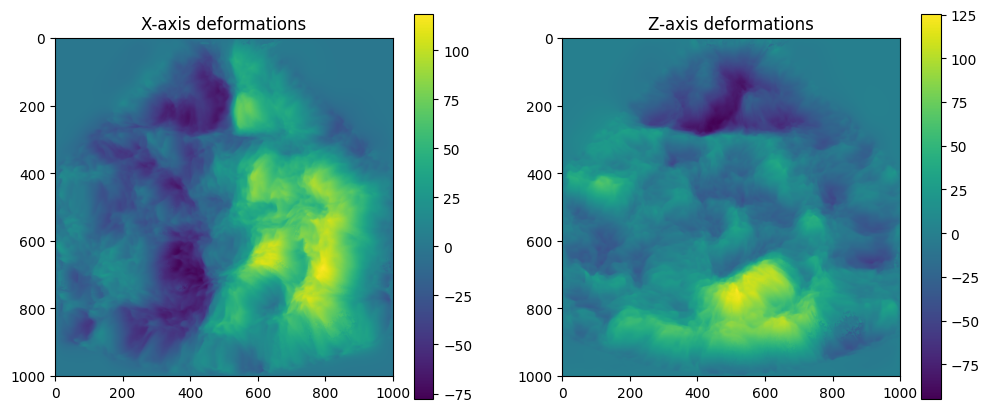

In [26]:
plt.viridis()
plt.figure(figsize=(12, 5), dpi=100)
plt.subplot(1,2,1)
plt.imshow(deform_forward[:,:,1])
plt.title('X-axis deformations')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(deform_forward[:,:,0])
plt.title('Z-axis deformations')
plt.colorbar()

In [36]:
# Generate ground truths
# pts = subprocess.run(["matlab", "-batch", f"test_eval(30,savedir,'PLA');"])
subprocess.run(["matlab", "-batch", f"get_eval_pts(50,'PLA',savedir);"])
pts1 = loadmat('eval_pts.mat')['pts']
pts0 = loadmat('eval_pts_0.mat')['pts']

pts0[:,2] = pts0[:,2] - 0.0045
pts1[:,2] = pts1[:,2] - 0.0045

suggest you rename the function to avoid a potential name conflict. 


Unrecognized function or variable 'savedir'.
 


(-0.05927525795479808,
 0.03146322610698879,
 -0.0897133313992036,
 -0.020998420835629906)

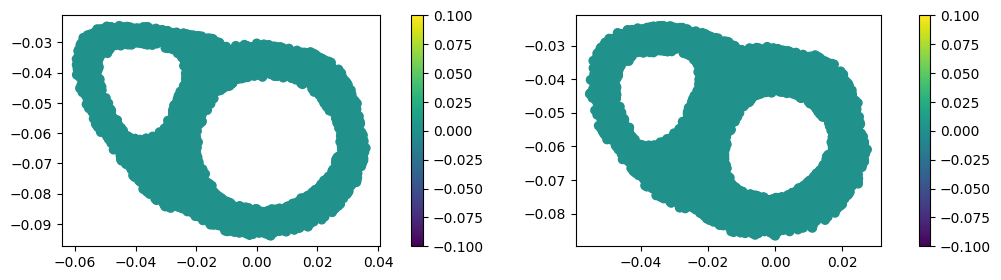

In [38]:
plt.figure(figsize=(12, 3), dpi=100)
plt.viridis()
plt.subplot(1,2,1)
plt.scatter(pts0[:,0],-pts0[:,2],c=pts0[:,3]);plt.colorbar()
plt.axis('image')
plt.subplot(1,2,2)
plt.scatter(pts1[:,0],-pts1[:,2],c=pts1[:,3]);plt.colorbar()
plt.axis('image')

In [11]:
gt = np.zeros([fixed.shape[0], fixed.shape[1], 4])

x = pxm['X']
z = pxm['Z']
y = pxm['Y']

for i in range(pts1.shape[0]):
    xind = np.where(np.abs(x - pts1[i,0]) == min(np.abs(x - pts1[i,0])))
    # yind = np.where(np.abs(x - pts[i,1]) == min(np.abs(x - pts[i,1])))
    zind = np.where(np.abs(z - pts1[i,2] + 0.005) == min(np.abs(z - pts1[i,2] + 0.005)))

    # print(pts[i,0]);print(x[xind])
    # print(pts[i,2]);print(z[zind])

    gt[zind, xind, 0] = pts1[i,3]
    gt[zind, xind, 1] = pts1[i,4]
    gt[zind, xind, 2] = 1
    gt[zind, xind, 3] = 1

In [12]:
gt = np.zeros([fixed.shape[0], fixed.shape[1], 4])

x = pxm['X']
z = pxm['Z']
y = pxm['Y']

for i in range(pts0.shape[0]):
    xind1 = np.where(np.abs(x - pts0[i,0]) == min(np.abs(x - pts0[i,0])))
    zind1 = np.where(np.abs(z - pts0[i,2]) == min(np.abs(z - pts0[i,2])))
    gt[zind1, xind1, 0] = 1


for i in range(pts1.shape[0]):
    xind2 = np.where(np.abs(x - pts1[i,0]) == min(np.abs(x - pts1[i,0])))
    zind2 = np.where(np.abs(z - pts1[i,2]) == min(np.abs(z - pts1[i,2])))
    gt[zind2, xind2, 1] = 1

Text(0.5, 1.0, 'Moving')

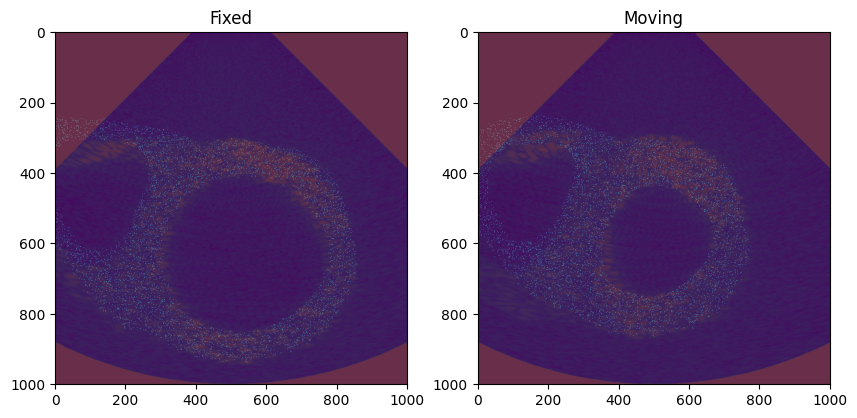

In [39]:
plt.figure(figsize=(10, 5), dpi=100)
plt.subplot(1,2,1)
plt.imshow(fixed)
plt.imshow(gt[:,:,0]*1000,alpha=0.8)
plt.title('Fixed')
plt.subplot(1,2,2)
plt.imshow(moving)
plt.imshow(gt[:,:,1]*1000,alpha=0.8)
plt.title('Moving')


# Error Calculation

In [16]:
indices = np.where(gt[:,:,0].flatten() == 0)[0]

a = gt[:,:,0].copy().flatten()
b = deform_forward[:,:,0].copy().flatten()
a = np.delete(a, indices)
b = np.delete(b, indices)

err = np.abs(a-b)

print('Minimum MAE:   ' + str(min(err)))
print('Average MAE:   ' + str(np.mean(err)))
print('Maximum MAE:   ' + str(max(err)))

Minimum MAE:   0.0012388229370117188
Average MAE:   21.233268223582808
Maximum MAE:   101.96463012695312


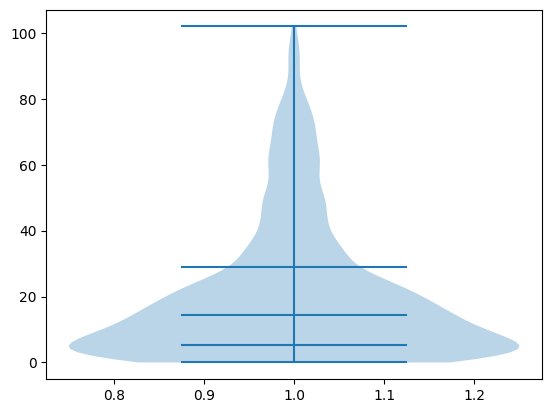

In [17]:
plt.violinplot(err, quantiles = [0.25,0.5,0.75]);

In [103]:
from scipy import signal

indices = np.where(gt[:,:,0].flatten() == 0)[0]

a = gt[:,:,0].copy().flatten()
b = deform_forward[:,:,0].copy().flatten()
a = np.delete(a, indices)
b = np.delete(b, indices)

ncc = np.correlate(a, b)

print('Minimum NMSE:   ' + str(min(ncc)))
print('Average NMSE:   ' + str(np.mean(ncc)))
print('Maximum NMSE:   ' + str(max(ncc)))

Minimum NMSE:   6.021346113739742
Average NMSE:   6.021346113739742
Maximum NMSE:   6.021346113739742


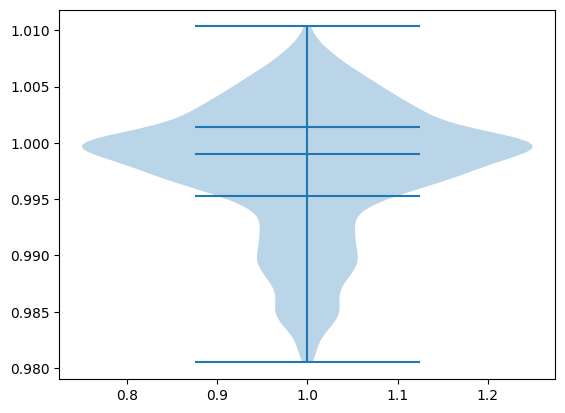

In [104]:
plt.violinplot(err, quantiles = [0.25,0.5,0.75]);

In [ ]:

indices = np.where(gt[:,:,2].flatten() == 0)[0]

# X-axis deformations
gtx = gt[:,:,0].copy().flatten()
dfx = deform_forward[:,:,0].copy().flatten()
gtx = np.delete(gtx, indices)
dfx = np.delete(dfx, indices)

maex = (gtx - dfx)
msex = (gtx - dfx)**2
# nmsex = ((gtx - dfx)**2) / (dfx**2)
nccx = norm_cross_corr(gtx, dfx)

# Z-axis deformations
gtz = gt[:,:,1].copy().flatten()
dfz = deform_forward[:,:,1].copy().flatten()
gtz = np.delete(gtz, indices)
dfz = np.delete(dfz, indices)

maez = (gtz - dfz)
msez = (gtz - dfz)**2
# nmsez = ((gtz - dfz)**2) / (dfz**2)
nccz = norm_cross_corr(gtz, dfz)

# New way

In [89]:
x = pxm['X']
z = pxm['Z']
y = pxm['Y']

newpts = np.zeros(pts0.shape)

for i in range(pts0.shape[0]):
    # Forward
    xind = np.where(np.abs(x - pts1[i,0]) == min(np.abs(x - pts1[i,0])))
    zind = np.where(np.abs(z - pts1[i,2]) == min(np.abs(z - pts1[i,2])))
    dx = deform_forward[zind,xind,1]
    dz = deform_forward[zind,xind,0]

    newpts[i,0] = pts1[i,0] + dx
    newpts[i,1] = pts1[i,2] + dz

    # Backward
    xind = np.where(np.abs(x - pts0[i,0]) == min(np.abs(x - pts0[i,0])))
    zind = np.where(np.abs(z - pts0[i,2]) == min(np.abs(z - pts0[i,2])))
    dx = deform_backward[zind,xind,1]
    dz = deform_backward[zind,xind,0]

    newpts[i,2] = pts0[i,0] + dx
    newpts[i,3] = pts0[i,2] + dz


Text(0.5, 1.0, 'GT, bwd')

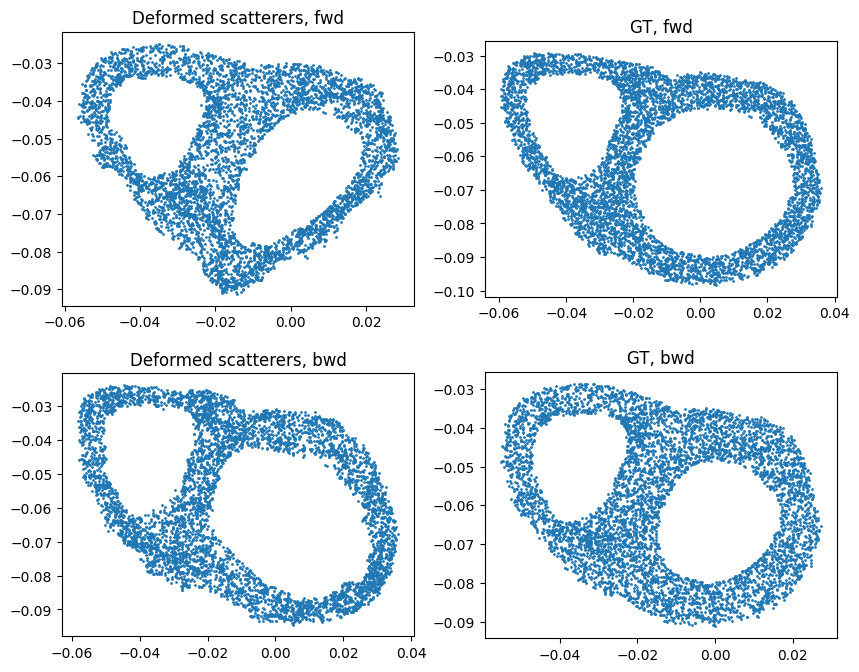

In [90]:
plt.figure(figsize=(10, 8), dpi=100)
plt.subplot(2,2,1)
plt.scatter(newpts[:,0],-newpts[:,1],1)
plt.axis('image')
plt.title('Deformed scatterers, fwd')
plt.subplot(2,2,2)
plt.scatter(pts0[:,0],-pts0[:,2]-0.0045,1)
plt.axis('image')
plt.title('GT, fwd')
plt.subplot(2,2,3)
plt.scatter(newpts[:,2],-newpts[:,3],1)
plt.axis('image')
plt.title('Deformed scatterers, bwd')
plt.subplot(2,2,4)
plt.scatter(pts1[:,0],-pts1[:,2]-0.0045,1)
plt.axis('image')
plt.title('GT, bwd')

In [112]:
ae = np.zeros([pts0.shape[0], 2])
ae[:,0] = pts0[:,0] - newpts[:,0]
ae[:,1] = pts0[:,2] - newpts[:,2]

In [130]:
np.median(ae[:,1])

0.0008059164409226424

Text(0.5, 1.0, 'Error in Z')

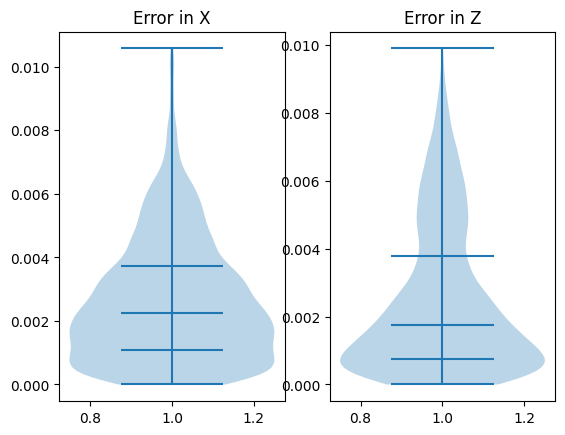

In [129]:
plt.figure()
plt.subplot(1,2,1)
plt.violinplot(np.abs(ae[:,0]),quantiles=[0.25, 0.5, 0.75])
plt.title('Error in X')
plt.subplot(1,2,2)
plt.violinplot(np.abs(ae[:,1]),quantiles=[0.25, 0.5, 0.75])
plt.title('Error in Z')

In [126]:
from scipy.stats import pearsonr
print(pearsonr(pts0[:,0],newpts[:,0]))
print(pearsonr(pts0[:,2],newpts[:,2]))

PearsonRResult(statistic=0.9946644612436288, pvalue=0.0)
PearsonRResult(statistic=0.9911512176170635, pvalue=0.0)
